# Pytorch

### By: [Natalí de Santi](https://natalidesanti.github.io), email: [natalidesanti@gmail.com](natalidesanti@gmail.com)

In this tutorial we will use `Pytorch` to solve a simple _regression problem_.

## Summary

* Importing the libraries
* Setting the CPU/GPU to use
* Generating the dataset
* Transforming the dataset to use it in `pytorch`
* Defining the model
* Defining the `optimizer` and `loss function`
* Training and validating the model
* Taking a look at the loss function
* Testing the model in the test set

## Running options

* **On the fly:** you can easily work with this notebook in `Google Colab`: [![Open this notebook in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/natalidesanti/pytorch_and_GNNs/blob/main/pytorch.ipynb)

* **Own computer:** otherwise you can download the notebook in your own computer and work with it in your own space. Just take care with the library dependencies. 

## 0) Importing the libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, TensorDataset
import time, sys, os
import matplotlib.pyplot as plt
import pandas as pd
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms

## 1) Setting the CPU/GPU to use

In [2]:
# Use GPU for training
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #For Linux
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") #For Macs
device

device(type='mps')

## 2) Generating the dataset

In [3]:
#Create Dataset 
def generate_data(a, b, num_examples):  
    '''
    Generate y = a x + b + noise
    '''

    x = np.random.uniform(0, 1, num_examples)
    y = a*x + b
    y += np.random.normal(0, 0.05, num_examples)

    df = pd.DataFrame(data = np.array([x, y]).T, columns = ['x', 'y'])
    
    return df

In [4]:
df = generate_data(0.5, 4.0, 2000)
df.head(5)

,x,y
0,0.364754,4.292016
1,0.665851,4.330926
2,0.166039,4.075114
3,0.980941,4.512910
4,0.599366,4.246022


Looking at the data

Text(0, 0.5, 'y')

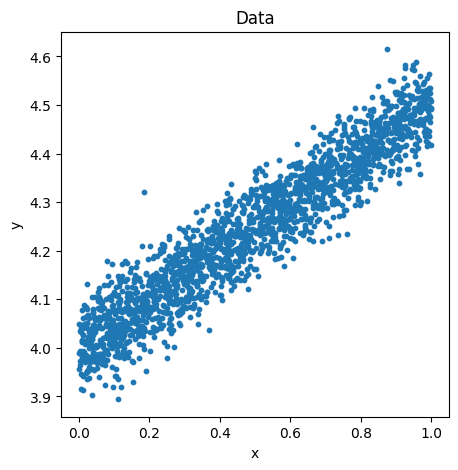

In [5]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.title('Data')
plt.scatter(df['x'], df['y'], s = 10)
plt.xlabel('x')
plt.ylabel('y')

In this tutorial we are going to:
$$\{x\} \Rightarrow \{y\}$$
using a simple **Neural Network** using `Pytorch`.

## 3) Transforming the dataset to use it in `pytorch`

1) We need to convert the data set in $3$ fractions:
* Train
* Validation
* Test
2) After this we need to transform the data set using:
\begin{equation}
 x \Rightarrow \frac{(x - x_{mean})}{x_{std}} ,
\end{equation}
\begin{equation}
 y \Rightarrow \frac{(y - y_{mean})}{(y_{max} - y_{min})} .
\end{equation}
This is done to constrain the range of all the input variables ($x$, $y$) to small and similar values to get a faster convergence of the method.
3) We need to convert the data into something to be understandable by `pytorch`. First we convert it in `tensors`, then, in `TensorDataSet`, and `DataLoader`. This last step split one more time the sets using `batches` (number of samples to work through before updating the internal model parameters).

In [6]:
def transform_dataset(df, frac_train, frac_val, batch_size):
    '''
    frac_train: fraction of the dataset to use in the training
    frac_val:   fraction of the dataset to use in the validation
    batch_size: number of samples to work through before updating the internal model parameters
    '''

    #Randomizing the dataset
    df = df.sample(frac = 1)

    #Getting the training, validation, and testing sets
    x_train = np.array( [ df['x'].iloc[:int(df.shape[0]*frac_train)] ] ).T
    y_train = np.array( [ df['y'].iloc[:int(df.shape[0]*frac_train)] ] ).T

    x_val = np.array( [ df['x'].iloc[int(df.shape[0]*frac_train):int(df.shape[0]*(frac_train + frac_val))] ] ).T
    y_val = np.array( [ df['y'].iloc[int(df.shape[0]*frac_train):int(df.shape[0]*(frac_train + frac_val))] ] ).T

    x_test = np.array( [ df['x'].iloc[int(df.shape[0]*(frac_train + frac_val)):] ] ).T
    y_test = np.array( [ df['y'].iloc[int(df.shape[0]*(frac_train + frac_val)):] ] ).T

    #Getting the statistics from the training set 
    mean = np.mean(x_train, axis = 0)
    std = np.std(x_train, axis = 0)
    min = np.mean(y_train, axis = 0)
    max = np.std(y_train, axis = 0)

    #Tranforming the training set
    x_train = (x_train - mean)/std
    x_val = (x_val - mean)/std
    x_test = (x_test - mean)/std

    y_train = (y_train - min)/(max - min)
    y_val = (y_val - min)/(max - min)
    y_test = (y_test - min)/(max - min)

    #Converting to torch reshaping
    x_train = torch.from_numpy(x_train.reshape(-1, 1)).float()
    y_train = torch.from_numpy(y_train.reshape(-1, 1)).float()

    x_val = torch.from_numpy(x_val.reshape(-1, 1)).float()
    y_val = torch.from_numpy(y_val.reshape(-1, 1)).float()

    x_test = torch.from_numpy(x_test.reshape(-1, 1)).float()
    y_test = torch.from_numpy(y_test.reshape(-1, 1)).float()

    #Converting to tensor dataset
    dataset_train = TensorDataset(x_train, y_train)
    dataset_val = TensorDataset(x_val, y_val)
    dataset_test = TensorDataset(x_test, y_test)

    #Organizing in batches
    train_loader = DataLoader(dataset = dataset_train, batch_size = batch_size)
    val_loader = DataLoader(dataset = dataset_val, batch_size = batch_size)
    test_loader = DataLoader(dataset = dataset_test, batch_size = batch_size)

    return train_loader, val_loader, test_loader, mean, std, max, min

In [7]:
train_loader, val_loader, test_loader, mean, std, max, min = transform_dataset(df, 0.8, 0.1, 100)

## 4) Defining the model

### 4.1. Neural Networks

A **neural network** is a collection of _nodes_ (neurons) that are arranged in a series of **layers**:

![](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/neutral-network-diagram.svg)
###### [Image source: [https://www.tibco.com/sites/tibco/files/media_entity/2021-05/neutral-network-diagram.svg](https://www.tibco.com/sites/tibco/files/media_entity/2021-05/neutral-network-diagram.svg)]

Each connection has a weight, $\omega_i a_i$, and each layer is a summarization of them, plus a bias $b$, according to:
\begin{equation}
 b_{\mu} + \sum_{\nu} W_{\mu \nu} a_{\nu} .
\end{equation}

Another numeric transformation called **activation function** is responsible for performing a non linear transformation of the values of each layer
\begin{equation}
 y_{\mu} = f \left( b_{\mu} + \sum_{\nu} W_{\mu \nu} a_{\nu} \right) ,
\end{equation}
This activation function can assume different forms:

![](https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)
###### [Image source: [https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png](https://miro.medium.com/max/1200/1*ZafDv3VUm60Eh10OeJu1vw.png)]

During the **training process** these _weights_ are adjusted through **epochs** in order to minimize the difference between the network predictions $y_{pred}$, and the target values $y_{target}$ through the minimization of a **loss function** (that also can assume different forms). In this tutorial we are going to use the **Mean Squared Error** (**MSE**)
\begin{equation}
 MSE = \frac{1}{m} \sum_{i = 1}^m (y_{pred} - y_{target})^2 .
\end{equation}

In [8]:
class model(nn.Module):
  def __init__(self):

    super(model, self).__init__() #Initiating the model

    #Defining the linear layers and activation function
    self.layer1 = nn.Linear(1, 8) 
    self.layer2 = nn.Linear(8, 16)
    self.layer3 = nn.Linear(16, 1)
    self.ReLU = nn.ReLU()

  #Forward pass
  def forward(self, x):
    '''
    Define the architecture at the same time as compute y
    '''
    x = self.ReLU(self.layer1(x))
    x = self.ReLU(self.layer2(x))
    y = self.layer3(x)
      
    return y

Instantiating the model

In [9]:
model = model().to(device)
model

model(
  (layer1): Linear(in_features=1, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (ReLU): ReLU()
)

Computing the number of parameters of the model

In [10]:
network_total_params = sum(p.numel() for p in model.parameters())

In [11]:
print('total number of parameters in the model = %d'%network_total_params)

total number of parameters in the model = 177


## 5) Defining the `optimizer` and `loss function`

* **optimizer:** algorithm that adjust the model parameters during training to minimize the loss function
* **loss function:** a mathematical function that quantifies the difference between predicted and actual values

In [12]:
optimizer = torch.optim.Adam(model.parameters())
loss_func = torch.nn.MSELoss()

## 6) Training and validating the model

In [13]:
epochs = 200 #Number of steps to train the model

lloss_train = []
lloss_val = []
for i in range(epochs):
  aux_train = 0
  model.train()  #Telling the model we are training :p
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)
    prediction = model(x)
    tloss = loss_func(prediction, y) 
    optimizer.zero_grad() #set the gradients to zero before starting to do backpropagation (i.e., updating the weights and biases)
    tloss.backward() #calculate the gradient during the backward pass in the neural network       
    optimizer.step() #performs a single optimization step (parameter update)
    aux_train += tloss.item()
  lloss_train.append( aux_train/len(train_loader) )     
  if i % 10 == 0:
    print(f"Epoch {i} | Train Loss {aux_train/len(train_loader)}")

  aux_val = 0
  model.eval() #Telling the model we are testing :p
  for x, y in val_loader:
    x = x.to(device)
    y = y.to(device)
    prediction = model(x)
    vloss = loss_func(prediction, y) 
    aux_val += vloss.item()
  lloss_val.append( aux_val/len(val_loader) )
  if i % 10 == 0:
    print(f"Epoch {i} | Val Loss {aux_val/len(val_loader)}")

Epoch 0 | Train Loss 0.010443492035847157
Epoch 0 | Val Loss 0.005457219900563359
Epoch 10 | Train Loss 0.00016560067342652474
Epoch 10 | Val Loss 0.00015971125685609877
Epoch 20 | Train Loss 0.00015371414610854117
Epoch 20 | Val Loss 0.00014673932309960946
Epoch 30 | Train Loss 0.00015030083613964962
Epoch 30 | Val Loss 0.0001441049898858182
Epoch 40 | Train Loss 0.00014908088496667915
Epoch 40 | Val Loss 0.00014293550339061767
Epoch 50 | Train Loss 0.0001488742268520582
Epoch 50 | Val Loss 0.00014244675548980013
Epoch 60 | Train Loss 0.00014885522659824346
Epoch 60 | Val Loss 0.00014166569599183276
Epoch 70 | Train Loss 0.00014901006943546236
Epoch 70 | Val Loss 0.00014105578884482384
Epoch 80 | Train Loss 0.0001486227588429756
Epoch 80 | Val Loss 0.00014142806321615353
Epoch 90 | Train Loss 0.00014801653424001415
Epoch 90 | Val Loss 0.00014246986393118277
Epoch 100 | Train Loss 0.00014745869066246087
Epoch 100 | Val Loss 0.00014312007988337427
Epoch 110 | Train Loss 0.00014699503935

## 7) Taking a look at the loss function

Here we can see if our model is **overfitting**, **underfitting** or doing well

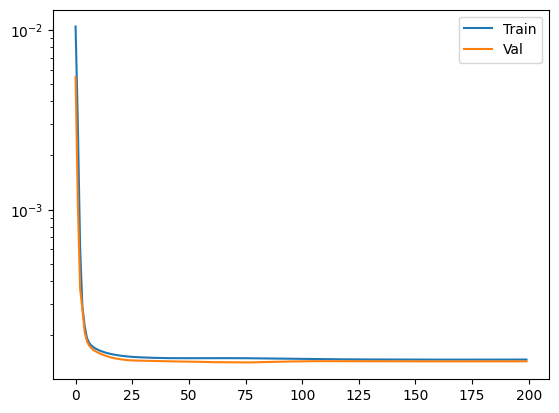

In [14]:
plt.figure(dpi = 100)
plt.plot(lloss_train, label = 'Train')
plt.plot(lloss_val, label = 'Val')
plt.legend()
plt.yscale('log')

## 8) Testing the model in the test set

In [15]:
lloss_test = []
preds = []
xss = []
yss = []
for x, y in test_loader:
  out = model( x.to(device))
  preds.append( out.detach().cpu().numpy() )
  xss.append( np.array( x ) )
  yss.append( np.array( y ) )
  loss = loss_func(out, torch.from_numpy( np.array(y[:, 0]) ).float().to(device))
lloss_test.append( loss.data.cpu().numpy() )

/Users/natalidesanti/env_pytorch/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Arranging the batches results

In [16]:
new_preds = np.concatenate( [preds[i] for i in range(len(preds))])
new_yss = np.concatenate( [yss[i] for i in range(len(yss))])
new_xss = np.concatenate( [xss[i] for i in range(len(xss))])
new_preds.shape, new_yss.shape, new_xss.shape

((200, 1), (200, 1), (200, 1))

In [17]:
df = pd.DataFrame()

df["x_truth"] = new_xss[:, 0]*std + mean
df["y_truth"] = new_yss[:, 0]*(max - min) + min
df["y_pred"] = new_preds[:, 0]*(max - min) + min

### 8.1) Computing the MSE for the test set

In [18]:
loss_test = np.mean(lloss_test)
loss_test

0.002418917

### 8.2) Looking at the predictions for the test set

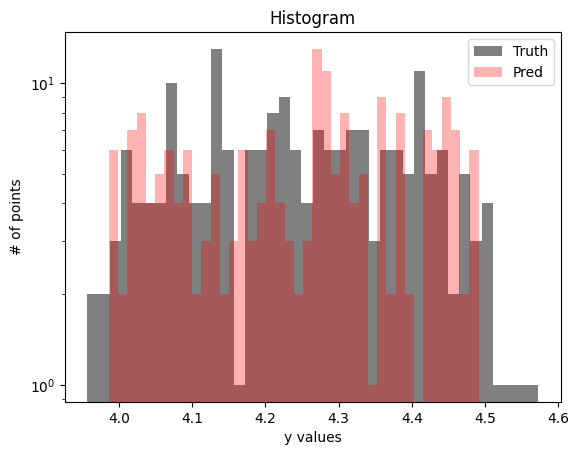

In [19]:
plt.figure(dpi = 100)
plt.title('Histogram')
plt.hist(df["y_truth"], bins = 40, label = 'Truth', color = "gray")
plt.hist(df["y_pred"], bins = 40, label = 'Pred', alpha = 0.3, color = "r")
plt.ylabel('# of points')
plt.xlabel('y values')
plt.legend()
plt.yscale('log')

Text(0.5, 0, 'Truth')

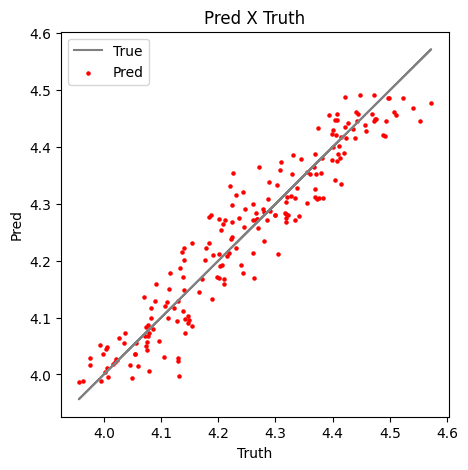

In [20]:
plt.figure(dpi = 100, figsize = (5, 5))
plt.title('Pred X Truth')
plt.plot(df["y_truth"], df["y_truth"], color = 'gray', label = 'True')
plt.scatter(df["y_truth"], df["y_pred"], c = 'r', s = 5, label = 'Pred')
plt.legend()
plt.ylabel('Pred')
plt.xlabel('Truth')